<a href="https://colab.research.google.com/github/imnabid/FaceTrace/blob/main/FaceTracemodel-training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'vgg-weights:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F4086983%2F7092045%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240926%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240926T151740Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D740e48de90a402679f49cd43573e11ad3ebc913e7af37cd4761c99c6d31a986eefb9a7cb6c9736ad37f7f0cf251cfb3c98905e6814ff1579bc2074d91c304624567c0ea1b8d54dcd925efbada8b2c45e3ebc917b02b8d602cede7ca7b415bdd56e2c41e961366293c2bb237f26b7c21d9f8a1de56252abb4966eba5afb87b22efbe7c18b9c0359a629a7e024d156094592731f4b2ec7ff51648b6d9e3201081648f46a553b1fc6e53c7a78f23c405376caf0a1824fb2c3e9f627cfd1396ce611bc5f58f0625fe38ca547580383bcf297daba0ce4e9374b7726e131508836737b45d0f3dcfee7e9a809d48ff935c56f04683db31801eaa7c39de2084f2f3906a0,new-images:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F4119025%2F7137730%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240926%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240926T151740Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3Dc9634f948606308e6989a691f66894ee09ba20cd5e87c126df121f8fb2e746993c8c2bdb59f8b0b57f8b10787aaad7236c7fef9b3e903003b2c175b88bdf31efb99d9d3cc3784b1184f9624430cddcad5ec2c302e2b1252cd9e91bbddd4bb2914c87f6b1569ec3e572b3cc3f03e664ac7a744ef490cd50102716acc67a820716222f7b3275ac2eef2902d8c8add9e0bbcd2ad1f80df3b5ab9cb2731f9709b3c29997892b54e2bd6f087e22a6ae0c3d28f1ee62d44cb45a9c0539acd8c514ecc56136cb607c1c99b870a81498781948a57f5641ea7fb9ffd2fddb5bc5d0e5e64f7391cf041087c108f7a9b00d0ef208a59ea6a33784a250bec261b0d02183ae09'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


# 1. Imports

In [ ]:
import os
import time
import cv2
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf


In [ ]:
tf.test.is_gpu_available()

True

In [ ]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'),
 PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]

#  **Siamese Network Data Prep**


In [ ]:
from sklearn.preprocessing import LabelEncoder

def load_and_label_images(DATA_PATH):
    training_images = []
    labels = []
    actors = os.listdir(DATA_PATH)

    for actor in actors[:20]:
        actor_folder = os.path.join(DATA_PATH, actor)
        images = os.listdir(actor_folder)
        for img in images:
            img = cv2.imread(os.path.join(actor_folder, img))
#             img = cv2.resize(img, (100, 100))
            training_images.append(img)
            labels.append(actor)
        print('done',actor)
    label_encoder = LabelEncoder()
    encoded_labels = label_encoder.fit_transform(labels)

    return np.array(training_images), np.array(encoded_labels)



In [ ]:
DATA_PATH = os.path.join('/kaggle/input/new-images/Celebrities Images')
training_images, labels = load_and_label_images(DATA_PATH)
np.unique(labels)

done Clean Dataset Arjun Rampal
done Clean Dataset Alia Bhatt
done Clean Dataset Brie Larson
done Clean Dataset Robert Downey Jr
done Clean Dataset Arjun Kapoor
done Clean Dataset Johnny Depp
done Clean Dataset Kate Winslet
done Clean Dataset Disha Patani
done Clean Dataset Brad Pitt
done Clean Dataset Parineeti Chopra
done Clean Dataset IIeana DCruz
done Clean Dataset Bhumi Padnekar
done Clean Dataset SHRADDHA KAPOOR
done Clean Dataset Elizabeth Olsen
done Clean Dataset YAMI GAUTAM
done Clean Dataset Leonardo DiCaprio
done Clean Dataset Denzel Washington
done Clean Dataset Sonakshi Sinha
done Clean Dataset Sanjay Dutt
done Clean Dataset Tom Cruise


array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19])

In [ ]:
np.where(labels != labels[4])

(array([ 30,  31,  32,  33,  34,  35,  36,  37,  38,  39,  40,  41,  42,
         43,  44,  45,  46,  47,  48,  49,  50,  51,  52,  53,  54,  55,
         56,  57,  58,  59,  60,  61,  62,  63,  64,  65,  66,  67,  68,
         69,  70,  71,  72,  73,  74,  75,  76,  77,  78,  79,  80,  81,
         82,  83,  84,  85,  86,  87,  88,  89,  90,  91,  92,  93,  94,
         95,  96,  97,  98,  99, 100, 101, 102, 103, 104, 105, 106, 107,
        108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120,
        121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133,
        134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146,
        147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159,
        160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172,
        173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185,
        186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198,
        199, 200, 201, 202, 203, 204, 205, 206, 207

In [ ]:
def pairing_images(images, labels):
    pair_images = []
    pair_labels = []
    unique_labels = np.unique(labels)

    #label and the indices in the labels dict
    labels_and_indices = dict()
    for l in unique_labels:
        labels_and_indices.setdefault(l, [i for i, label in enumerate(labels) if label==l])

    for index, img in enumerate(images):
        pos_index = np.random.choice(labels_and_indices.get(labels[index]))
        pos_image = images[pos_index]
        pair_images.append((img, pos_image))
        pair_labels.append(1)

        neg_index = np.random.choice(np.where(labels != labels[index])[0]) #np.random.choice returns a tuple
        neg_img = images[neg_index]
        pair_images.append((img, neg_img))
        pair_labels.append(0)

    return np.array(pair_images), np.array(pair_labels)

In [ ]:
i_pairs, pair_labels = pairing_images(training_images, labels)

In [ ]:
indices = np.random.permutation(len(i_pairs))
training_img_pairs = i_pairs[indices]
training_labels = pair_labels[indices]


Displaying test images

In [ ]:
def show_images(img_pairs, title):
    n = len(img_pairs)
    fig, axes = plt.subplots(n, 2)
    fig.suptitle(title)
    for i,img_pair in enumerate(img_pairs):
        axes[i,0].imshow(img_pair[0])

        axes[i,1].imshow( img_pair[1])

    plt.tight_layout()
    plt.show()


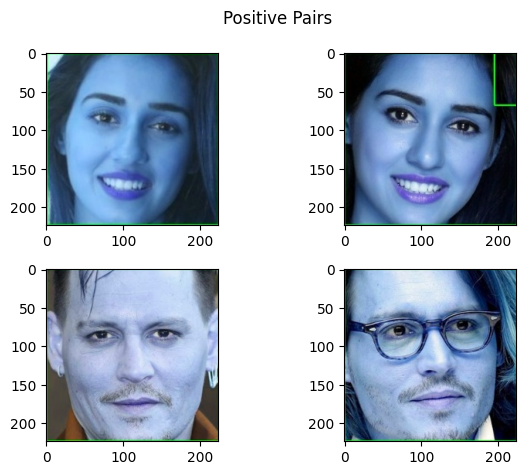

In [ ]:
#display positive pair
pair_num = 2
indices = np.where(training_labels == 1)[0]
pair_indices = np.random.choice(indices, pair_num)
pairs = [training_img_pairs[i] for i in pair_indices]
show_images(pairs, 'Positive Pairs')


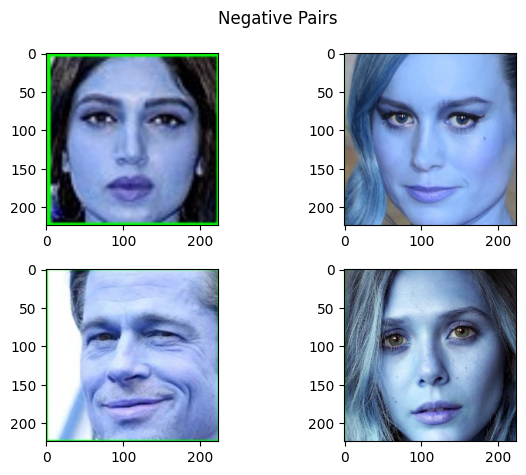

In [ ]:
#Display negative pair
pair_num = 2
indices = np.where(training_labels == 0)[0]
pair_indices = np.random.choice(indices, pair_num)
pairs = [training_img_pairs[i] for i in pair_indices]
show_images(pairs, 'Negative Pairs')

In [ ]:
training_img_pairs.shape

(1200, 2, 224, 224, 3)

### Train Test Split

In [ ]:

X_train = training_img_pairs
y_train = np.expand_dims(training_labels, axis=1)
y_train[:22]

array([[1],
       [0],
       [1],
       [1],
       [0],
       [1],
       [1],
       [0],
       [1],
       [1],
       [0],
       [1],
       [1],
       [0],
       [1],
       [0],
       [1],
       [0],
       [1],
       [1],
       [0],
       [0]])

## Defining Custom Layers

In [ ]:
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
import tensorflow.keras.backend as K
from tensorflow.keras.models import Model
from tensorflow.keras import Sequential
from tensorflow.keras import layers
from tensorflow.keras.layers import Convolution2D, ZeroPadding2D, Activation, Layer, Input, Dense, Flatten, Conv2D, MaxPooling2D, Dropout

class DistanceLayer(Layer):

    def __init__(self, **kwargs):
        super().__init__(**kwargs)

    def call(self, source_representation, test_representation):
        euclidean_distance = source_representation - test_representation
        euclidean_distance = tf.multiply(euclidean_distance,euclidean_distance)
        euclidean_distance = tf.reduce_sum(euclidean_distance, axis=1)
        euclidean_distance = tf.sqrt(euclidean_distance)
        euclidean_distance = tf.reshape(euclidean_distance, (-1,1))
        return euclidean_distance

class ThresholdLayer(Layer):

    def __init__(self, threshold, **kwargs):
        super().__init__(**kwargs)
        self.threshold = threshold

    def call(self, distances):
        return tf.map_fn(fn=lambda t: float(t <= self.threshold), elems=distances)

## VGG16 Architecture

In [ ]:
model = Sequential()
model.add(ZeroPadding2D((1,1),input_shape=(224,224, 3)))
model.add(Convolution2D(64, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2,2), strides=(2,2)))

model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(128, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D((2,2), strides=(2,2)))

model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(256, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(256, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(256, (3, 3), activation='relu'))
model.add(MaxPooling2D((2,2), strides=(2,2)))

model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(512, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(512, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(512, (3, 3), activation='relu'))
model.add(MaxPooling2D((2,2), strides=(2,2)))

model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(512, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(512, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(512, (3, 3), activation='relu'))
model.add(MaxPooling2D((2,2), strides=(2,2)))

model.add(Convolution2D(4096, (7, 7), activation='relu'))
model.add(Dropout(0.5))
model.add(Convolution2D(4096, (1, 1), activation='relu'))
model.add(Dropout(0.5))
model.add(Convolution2D(2622, (1, 1)))
model.add(Flatten())
model.add(Activation('softmax'))

In [ ]:
model.load_weights('/kaggle/input/vgg-weights/vgg_face_weights.h5')
# for layer in model.layers:
#     layer.trainable = False

In [ ]:
siamese_model = Model(inputs=model.input
, outputs=model.layers[-2].output)
siamese_model.summary()


Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 zero_padding2d_13_input (I  [(None, 224, 224, 3)]     0         
 nputLayer)                                                      
                                                                 
 zero_padding2d_13 (ZeroPad  (None, 226, 226, 3)       0         
 ding2D)                                                         
                                                                 
 conv2d_16 (Conv2D)          (None, 224, 224, 64)      1792      
                                                                 
 zero_padding2d_14 (ZeroPad  (None, 226, 226, 64)      0         
 ding2D)                                                         
                                                                 
 conv2d_17 (Conv2D)          (None, 224, 224, 64)      36928     
                                                           

## Combined Final Model

In [ ]:
#overall model
input_shape=(224,224,3)
anchor = Input(name='anchor', shape=input_shape)
compare = Input(name='compare', shape=input_shape)

distances = DistanceLayer()(
    siamese_model(anchor),
    siamese_model(compare)
)
outputs = ThresholdLayer(threshold=115)(distances)

# outputs = Dense(1, activation='sigmoid')(distances)
facetrace_model = Model(inputs=[anchor, compare], outputs=outputs, name='FaceTrace')
facetrace_model.summary()






Model: "FaceTrace"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 anchor (InputLayer)         [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 compare (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 model_1 (Functional)        (None, 2622)                 1450028   ['anchor[0][0]',              
                                                          78         'compare[0][0]']             
                                                                                                  
 distance_layer_1 (Distance  (None, 1)                    0         ['model_1[0][0]',     

# Training / Finetuning the Model

In [ ]:
def preprocess_image(img):
    img = tf.keras.applications.vgg16.preprocess_input(img)
    return img

In [ ]:
im1 = preprocess_image(X_train[:,0,:])
im2 = preprocess_image(X_train[:,1,:])

In [ ]:
im1.shape

(1200, 224, 224, 3)

In [ ]:
y_train.shape

(1200, 1)

In [ ]:
y_train[0]

array([1])

In [ ]:
adam_optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

In [ ]:
facetrace_model.compile(optimizer=adam_optimizer, loss='binary_crossentropy', metrics=['accuracy'])


In [ ]:
history = facetrace_model.fit(x=[im1, im2], y=y_train, epochs=15, batch_size=32, validation_split = 0.2)

Epoch 1/15


2024-01-03 18:48:49.127716: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inFaceTrace/model_1/dropout_2/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


30/30 [==============================] - 71s 2s/step - loss: 6.4908 - accuracy: 0.5792 - val_loss: 2.4335 - val_accuracy: 0.8417
Epoch 2/15
30/30 [==============================] - 42s 1s/step - loss: 6.4751 - accuracy: 0.5802 - val_loss: 2.4335 - val_accuracy: 0.8417
Epoch 3/15
30/30 [==============================] - 42s 1s/step - loss: 6.5072 - accuracy: 0.5781 - val_loss: 2.4335 - val_accuracy: 0.8417
Epoch 4/15
30/30 [==============================] - 42s 1s/step - loss: 6.3135 - accuracy: 0.5906 - val_loss: 2.4335 - val_accuracy: 0.8417
Epoch 5/15
30/30 [==============================] - 42s 1s/step - loss: 6.3783 - accuracy: 0.5865 - val_loss: 2.4335 - val_accuracy: 0.8417
Epoch 6/15
30/30 [==============================] - 42s 1s/step - loss: 6.4743 - accuracy: 0.5802 - val_loss: 2.4335 - val_accuracy: 0.8417
Epoch 7/15
30/30 [==============================] - 42s 1s/step - loss: 6.3779 - accuracy: 0.5865 - val_loss: 2.4335 - val_accuracy: 0.8417
Epoch 8/15
30/30 [=============

In [ ]:
#facetrace_model.save('facetraceV1.keras',save_format='keras')

In [ ]:
import random, json
indices = random.choices(range(6295), k=500)
# indices  = [4764,5000,6265,3930,2580,2865,1978,5211,1277,5139,216,2500,2279,2920,4010,5515,4309,3468,4456,1215,4595,2923,5122,4204,1723,2425,2701,1465,3954,4522,65,6264,5925,6101,4020,1859,2450,4281,3948,491,2237,6201,784,528,1442,2884,4801,2172,375,861,1037,5209,3711,6206,3701,206,3027,1841,388,1740,2946,5761,3889,2959,4886,2531,3629,3780,1769,265,113,1781,2053,57,4590,507,5171,814,5297,2682,355,4303,4817,6077,1551,1102,457,5176,4248,5309,1928,3313,2629,1247,2140,831,5657,2960,2129,4160,569,5224,4875,1002,5402,868,3364,1891,5438,492,2018,3484,2233,3176,1165,2770,1721,4677,2432,5643,4566,4534,5063,4406,3217,4647,1962,572,4457,5855,1400,5428,2763,3142,5307,2671,2490,21,2746,5385,483,3094,1070,3643,3773,1607,1349,1847,3802,5436,3492,2128,3683,3859,635,4596,5838,4991,4392,5501,3914,2819,4351,3514,5030,2626,1985,5717,4128,3186,4169,5509,2835,1194,2286,203,4555,2887,5074,2872,3107,5119,4826,1805,3059,3265,1381,1463,6203,4521,1428,5557,1236,3183,4638,2320,2349,5342,4808,4140,3533,2197,1524,3704,811,1103,5231,2899,3276,2841,4297,2961,1509,1223,4067,4395,2003,57,3439,5083,5748,4236,3737,2582,441,4132,1455,6181,2567,5126,5504,808,1130,3518,6140,4438,572,2027,2594,4166,946,4137,3541,4820,3623,963,5322,6292,1807,1042,5562,865,2432,308,2790,4080,2936,1901,294,2740,2334,4274,33,388,2540,983,4609,4771,4641,4054,1926,561,4297,1426,5354,1356,5983,6248,5738,1996,3626,2260,585,4364,1808,1802,1038,2844,6000,1441,4606,1670,3708,5898,6257,891,3560,2316,4692,1467,3790,3211,725,5395,5910,1239,523,1845,3661,4788,4681,5862,2587,4426,2833,2154,3582,4172,1634,4026,778,4198,4138,3119,1554,472,61,1614,2183,5979,1367,1075,1438,650,1370,21,565,10,1332,3189,375,174,5040,2767,424,3445,142,2832,2370,1638,3469,5437,1494,4696,5601,3730,5909,5846,4403,490,926,2293,3276,6036,310,6159,15,4462,5771,5278,115,3559,2553,809,2280,3379,5890,400,4749,1799,76,4922,2108,1650,1047,6006,3678,5899,4353,6247,3662,2317,2090,797,882,1277,3460,3769,787,3062,3431,4858,5202,2983,721,5612,5604,5713,5027,2378,1054,1721,3489,2896,2056,989,4441,4611,2689,6253,3068,434,489,4708,2998,42,5748,5710,3772,150,532,2493,5303,3768,2060,4495,2472,1141,724,2790,1527,1240,5692,3404,2787,680,1840,3224,5447,1736,5849,1619,5057,5677,1331,5717,5602,372,3186,4421,6204,4303,1008,1165,6030,3916,4702,1738,6182,3227,75,2989,4590,3003,4402,1311,1941,1964,3802,3476,2185,4387,328,2937,2207,6064,4096,2058,3321,6116,1687,2613,4727,168,5981,5793,221,1405,1229,1671]
# with open('j.json', 'r') as file:
#     indices = json.load(file)
test_pairs = X_train[indices]
real_y = y_train[indices]

In [ ]:
show_images(test_pairs[:3],'tt')

In [ ]:
x1 = preprocess_image(test_pairs[:,0,:])
x2 = preprocess_image(test_pairs[:,1,:])

In [ ]:
y_pred = facetrace_model.predict([x1, x2])

In [ ]:
y_pred[:10]

In [ ]:
real_y[:10]

In [ ]:
m = tf.keras.metrics.Accuracy()
m.update_state(real_y, y_pred)
m.result().numpy()